In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sn
import pickle

from matplotlib import pyplot as plt
from io import StringIO
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, f1_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df_listings_details = pd.read_csv('../data/listings_detailed.csv')
df_listings = pd.read_csv('../data/listings.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

In [4]:
selected_columns = ['room_type', 'minimum_nights', 'neighbourhood',
   'availability_eoy', 'availability_365', 
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified',
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'estimated_occupancy_l365d', 'estimated_revenue_l365d',
    'number_of_reviews', 'number_of_reviews_l30d', 'reviews_per_month', 
    'review_scores_rating', 'review_scores_value', 
    'instant_bookable', 'calculated_host_listings_count', 'price']


In [5]:
def normalize_rooms(df):
    unique_rooms = df['room_type'].unique()
    for g in unique_rooms:
        df[g] = df['room_type'].apply(lambda x: g in x)
    df = df.drop('room_type', axis=1)
    return df

In [6]:
def normalize_locations(df):
    unique_rooms = df['neighbourhood_grouped'].unique()
    for g in unique_rooms:
        df[g] = df['neighbourhood_grouped'].apply(lambda x: g in x)
    df = df.drop('neighbourhood_grouped', axis=1)
    df = df.drop('neighbourhood', axis=1)
    return df

In [7]:
def group_neighborhoods(df, min_count=300, neighborhood_col='neighbourhood'):
    room_counts = df[neighborhood_col].value_counts()
    neighborhoods_to_keep = room_counts[room_counts >= min_count].index.tolist()
    df['neighbourhood_grouped'] = df[neighborhood_col].apply(
        lambda x: x if x in neighborhoods_to_keep else 'Others'
    )
    return df

In [8]:
def normalize_tf_cols(df, column):
    df[column] = df[column].replace({'t': 1, 'f': 0}).astype(bool)
    return df

In [9]:
def fix_encoding(df_cleaned):
    encoding_map = {}
    for val in df_cleaned['neighbourhood'].unique():
        try:
            clean_val = val.encode("latin1").decode("utf-8", errors="ignore")
            encoding_map[val] = clean_val
        except (UnicodeEncodeError, AttributeError):
            encoding_map[val] = val
    df_cleaned['neighbourhood'] = df_cleaned['neighbourhood'].map(encoding_map)
    return df_cleaned

In [10]:
def data_cleanup(df_1, df_2):
    df_merged_listings = pd.concat([df_listings, df_listings_details], axis=1)
    df_merged_listings = df_merged_listings.loc[:, ~df_merged_listings.columns.duplicated()]
    df_cleaned = df_merged_listings[selected_columns].dropna() 
    df_cleaned = df_cleaned[df_cleaned['availability_eoy']> 0]
    df_cleaned = df_cleaned[df_cleaned['availability_365']> 0]
    df_cleaned = df_cleaned[df_cleaned['estimated_occupancy_l365d']> 0]
    df_cleaned['host_response_rate'] = df_cleaned['host_response_rate'].str.replace('%', '', regex=False).astype(float)
    df_cleaned['host_acceptance_rate'] = df_cleaned['host_acceptance_rate'].str.replace('%', '', regex=False).astype(float)
    df_cleaned = normalize_rooms(df_cleaned)
    df_cleaned = normalize_tf_cols(df_cleaned, 'instant_bookable')
    df_cleaned = normalize_tf_cols(df_cleaned, 'host_identity_verified')
    df_cleaned = normalize_tf_cols(df_cleaned, 'host_is_superhost')
    df_cleaned = fix_encoding(df_cleaned)
    df_cleaned.columns = df_cleaned.columns.str.replace('/','_')
    df_cleaned = group_neighborhoods(df_cleaned, 300, 'neighbourhood')
    df_cleaned = normalize_locations(df_cleaned)
    df_cleaned.columns = df_cleaned.columns.str.lower()
    df_cleaned.columns = df_cleaned.columns.str.replace(' ','_')
    return df_cleaned

In [11]:
df_cleaned = data_cleanup(df_listings, df_listings_details)

In [12]:
df_cleaned['log_price'] = np.log1p(df_cleaned['price'])

In [13]:
interested_features = ['minimum_nights',
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified',
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'number_of_reviews', 'review_scores_rating',  
    'instant_bookable', 'entire_home_apt', 'private_room', 'shared_room', 'hotel_room',          
    'leopoldstadt', 'others', 'margareten', 'brigittenau', 'landstrae', 'ottakring', 
    'rudolfsheim-fnfhaus', 'neubau', 'alsergrund', 'meidling', 'favoriten']

target = 'log_price'

In [14]:
X_full = df_cleaned[interested_features]
y_full = df_cleaned[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
len(X_train), len(X_val), len(X_test)

(4076, 1359, 1359)

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [16]:
y_pred_linear_val = lin_reg.predict(X_val)

In [17]:
r2s_lin_reg = r2_score(y_val, y_pred_linear_val)
rmse_lin_reg = mean_squared_error(y_val, y_pred_linear_val) 

print("R^2 Score", r2s_lin_reg)
print("RMSE", rmse_lin_reg)

np.set_printoptions(suppress=True, precision=6)
coefficients = pd.DataFrame({'feature':interested_features, 'coefficient' : lin_reg.coef_})
coefficients_desc = coefficients.round(4).sort_values(by=['coefficient'], ascending=False)
print(coefficients_desc)

R^2 Score 0.397934208805078
RMSE 0.17004640489397715
                   feature  coefficient
15              hotel_room       0.5153
12         entire_home_apt       0.3633
6                bathrooms       0.1706
16            leopoldstadt       0.1687
23                  neubau       0.1657
10    review_scores_rating       0.1516
7                 bedrooms       0.1441
20               landstrae       0.1178
3        host_is_superhost       0.1160
11        instant_bookable       0.1061
17                  others       0.1056
24              alsergrund       0.0783
5             accommodates       0.0506
2     host_acceptance_rate       0.0001
9        number_of_reviews      -0.0003
1       host_response_rate      -0.0028
0           minimum_nights      -0.0047
8                     beds      -0.0075
18              margareten      -0.0093
26               favoriten      -0.0901
22     rudolfsheim-fnfhaus      -0.1010
19             brigittenau      -0.1028
13            private_room 

In [18]:
correlation_columns = [
    'host_identity_verified',
    'host_is_superhost', 
    'host_response_rate',
    'host_acceptance_rate',
    'review_scores_rating',
    'number_of_reviews',
    'instant_bookable',
    'log_price'  
]

corr_matrix = df_cleaned[correlation_columns].corr()
print("Correlation Matrix for Host-Related Features:")
print(corr_matrix.round(3))

Correlation Matrix for Host-Related Features:
                        host_identity_verified  host_is_superhost  \
host_identity_verified                   1.000              0.092   
host_is_superhost                        0.092              1.000   
host_response_rate                       0.034              0.149   
host_acceptance_rate                    -0.037              0.056   
review_scores_rating                     0.035              0.327   
number_of_reviews                        0.112              0.244   
instant_bookable                        -0.082             -0.182   
log_price                               -0.105              0.128   

                        host_response_rate  host_acceptance_rate  \
host_identity_verified               0.034                -0.037   
host_is_superhost                    0.149                 0.056   
host_response_rate                   1.000                 0.552   
host_acceptance_rate                 0.552                 1

In [19]:
rf_regression= RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=-1)
rf_regression.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
y_pred_rf_val = rf_regression.predict(X_val)

In [21]:
print("R^2 Score", r2_score(y_val, y_pred_rf_val))
print("RMSE", mean_squared_error(y_val, y_pred_rf_val))

R^2 Score 0.4104899273675121
RMSE 0.1665001897898686


In [22]:
interested_features

importances = rf_regression.feature_importances_
most_important_index = np.argmax(importances)
most_important_index
most_important_feature = interested_features[most_important_index]
print(most_important_feature)

feat_imp = pd.Series(importances, index=X_full.columns).sort_values(ascending=False)
print(feat_imp)

bedrooms
bedrooms                  0.206548
review_scores_rating      0.119106
number_of_reviews         0.115160
bathrooms                 0.075163
entire_home_apt           0.072826
host_acceptance_rate      0.070555
minimum_nights            0.059291
host_response_rate        0.045826
accommodates              0.043374
beds                      0.031652
others                    0.022455
host_identity_verified    0.021669
host_is_superhost         0.019693
instant_bookable          0.019002
leopoldstadt              0.015124
landstrae                 0.009874
favoriten                 0.009366
rudolfsheim-fnfhaus       0.008415
alsergrund                0.006750
neubau                    0.006567
ottakring                 0.005630
brigittenau               0.005577
meidling                  0.004634
margareten                0.003023
private_room              0.001493
hotel_room                0.000868
shared_room               0.000361
dtype: float64


In [23]:
def random_forest_varied_depth_estimator(depth, estimator):
    rf= RandomForestRegressor(n_estimators=estimator,max_depth=depth, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2s = r2_score(y_val, y_pred)
    return rmse, r2s

In [24]:
def find_best_depth_estimator():
    depths = [10,15,20,25, 30, 35]
    estimators = np.arange(10,210,10)

    rmse_summary = {}
    r2s_summary = {}
    results_list = []
    
    for depth in depths:
        rmses=[]
        r2ses=[]
        for estimator in estimators:
            rmse, r2s = random_forest_varied_depth_estimator(depth, estimator)
            rmses.append(rmse)
            r2ses.append(r2s)
            results_list.append({
                'depth' : depth,
                'estimator' : estimator,
                'rmse': rmse,
                'r2s' : r2s
            })
            
        rmse_summary[depth] = np.mean(rmses)
        r2s_summary[depth] = np.mean(r2ses)

    best_depth= min(rmse_summary, key=rmse_summary.get)
    
    results_df=pd.DataFrame(results_list)
    best_results_from_max_depth = results_df[results_df['depth']==best_depth]
    
    best_result_row = best_results_from_max_depth.loc[best_results_from_max_depth['rmse'].idxmin()]
    best_estimator = int(best_result_row['estimator'])
    return best_depth, best_estimator

In [25]:
best_max_depth, best_estimator = find_best_depth_estimator()
print("MAX Depth : ",best_max_depth)
print("Estimator : ",best_estimator)

best_rf_regressor = RandomForestRegressor(n_estimators=best_estimator,random_state=42, n_jobs=-1, max_depth=best_max_depth)
best_rf_regressor.fit(X_train, y_train)

y_pred_best_rf_val = rf_regression.predict(X_val)

MAX Depth :  25
Estimator :  200


In [26]:
print(best_max_depth, best_estimator)
r2s_rf_reg  = r2_score(y_val, y_pred_best_rf_val)
rmse_rf_reg = mean_squared_error(y_val, y_pred_best_rf_val)

print("R2 Square of Random Forest : ", r2s_rf_reg)
print("RMSE of Random Forest : ", rmse_rf_reg)

25 200
R2 Square of Random Forest :  0.4104899273675121
RMSE of Random Forest :  0.1665001897898686


In [27]:
if(rmse_rf_reg < rmse_lin_reg):
    print("Random Forest is better")
else:
    print("Linear Regression is better")

Random Forest is better



Gradient Boosting Results:
RMSE: 0.38
R² Score: 0.4829
MAE: 0.29

 Feature Importance:
                   feature  importance
7                 bedrooms    0.337246
12         entire_home_apt    0.118797
6                bathrooms    0.109252
5             accommodates    0.071499
10    review_scores_rating    0.071338
1       host_response_rate    0.045587
0           minimum_nights    0.043645
4   host_identity_verified    0.034236
2     host_acceptance_rate    0.026462
9        number_of_reviews    0.025049
11        instant_bookable    0.016088
3        host_is_superhost    0.015998
17                  others    0.015383
16            leopoldstadt    0.012197
21               ottakring    0.011711
26               favoriten    0.007455
20               landstrae    0.006762
25                meidling    0.006731
13            private_room    0.004226
22     rudolfsheim-fnfhaus    0.003873
23                  neubau    0.003846
8                     beds    0.003564
14             

Text(0, 0.5, 'Feature')

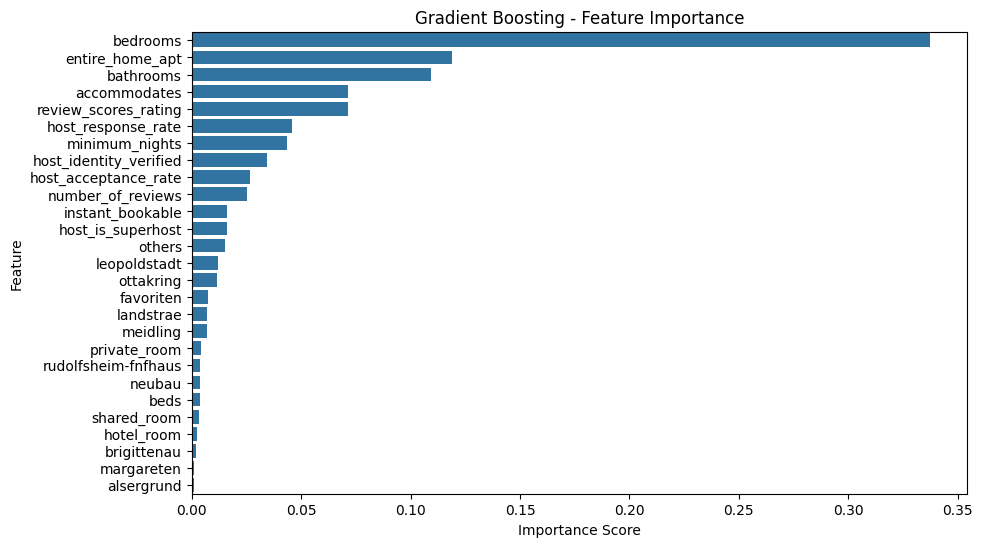

In [28]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # How much each tree contributes
    max_depth=3,           # Maximum depth of each tree
    min_samples_split=2,   # Minimum samples required to split
    min_samples_leaf=1,    # Minimum samples required at leaf node
    random_state=42
)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_val_gb = gb_model.predict(X_val)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val_gb))
r2 = r2_score(y_val, y_pred_val_gb)
mae = mean_absolute_error(y_val, y_pred_val_gb)

print("\nGradient Boosting Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")


feature_importance = pd.DataFrame({
    'feature': X_full.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sn.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Gradient Boosting - Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

In [29]:
print("Model Type:", type(gb_model))
print("Model Parameters:", gb_model.get_params())

Model Type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Model Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [30]:
import xgboost as xgb

In [31]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,              # Number of trees
    learning_rate=0.1,             # Step size shrinkage
    max_depth=3,                   # Maximum tree depth
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_compare_xgb_vals = xgb_model.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred_compare_xgb_vals))
r2 = r2_score(y_val, y_pred_compare_xgb_vals)
mae = mean_absolute_error(y_val, y_pred_compare_xgb_vals)

print("XGBoost Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")

XGBoost Results:
RMSE: 0.38
R² Score: 0.4873
MAE: 0.29


In [32]:
model_params = xgb_model.get_xgb_params()
print(model_params)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Name of Model Linear Regression
Name of Model Random Forest
Name of Model Gradient Boosting
Name of Model XGB Regression

Model Comparison:
                     RMSE      R²     MAE
Linear Regression  0.4124  0.3979  0.3127
Random Forest      0.3902  0.4610  0.2973
Gradient Boosting  0.3822  0.4829  0.2937
XGB Regression     0.3806  0.4873  0.2933


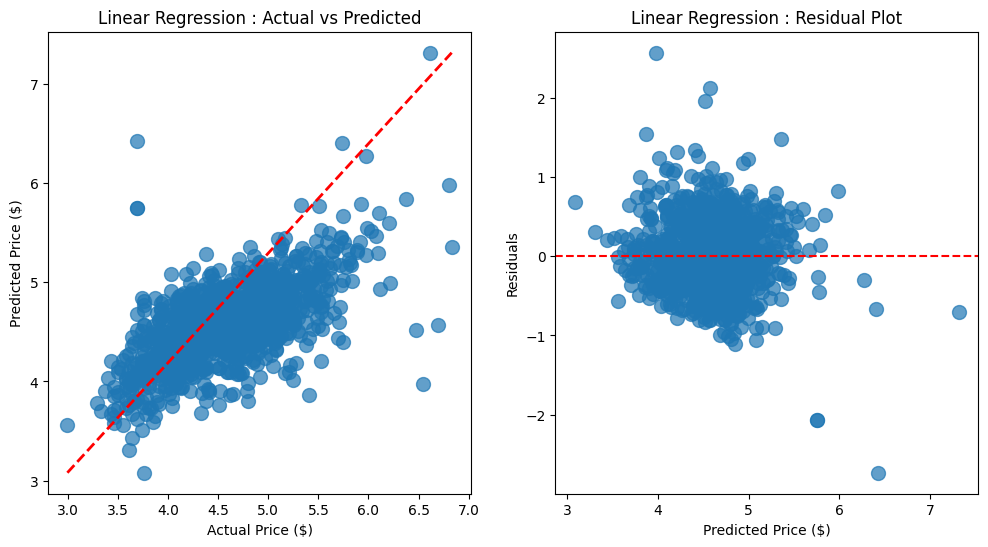

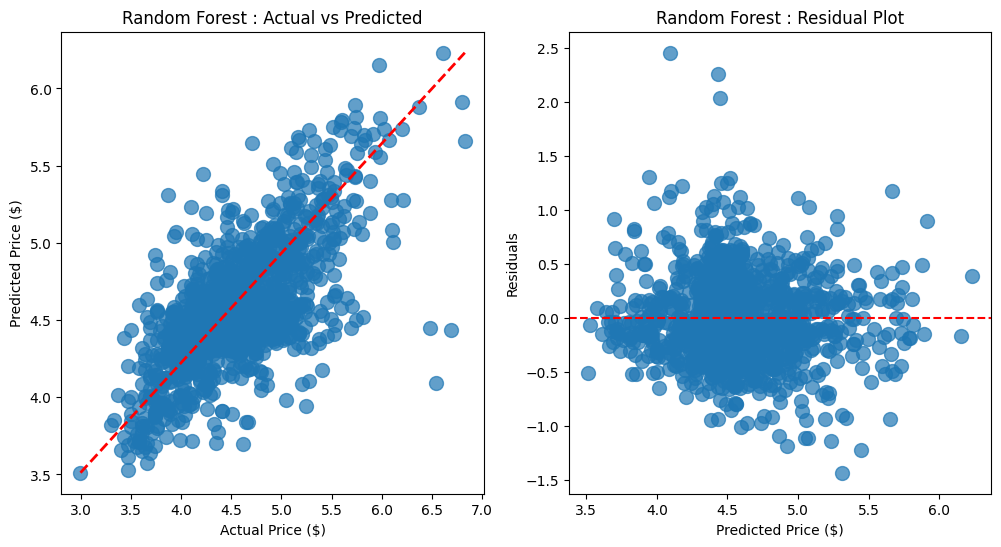

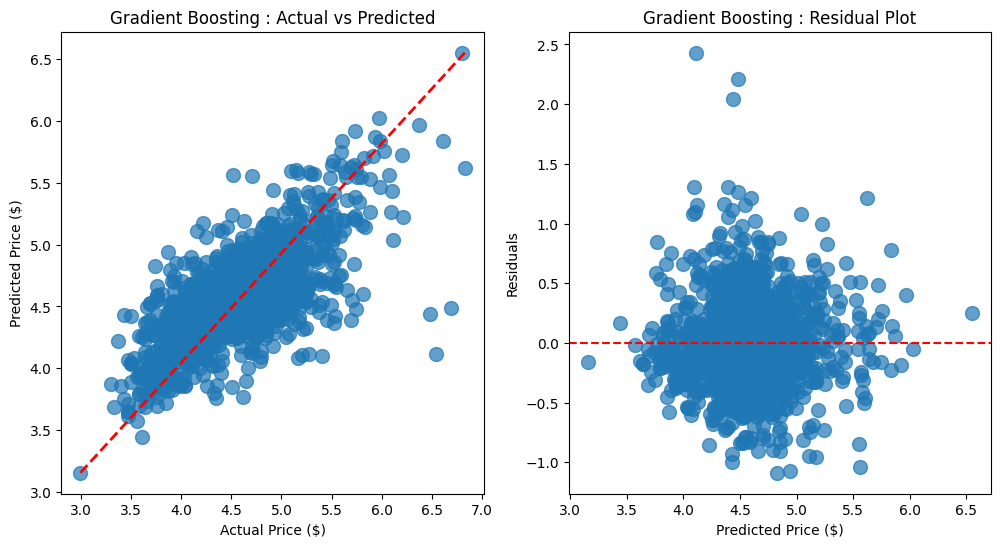

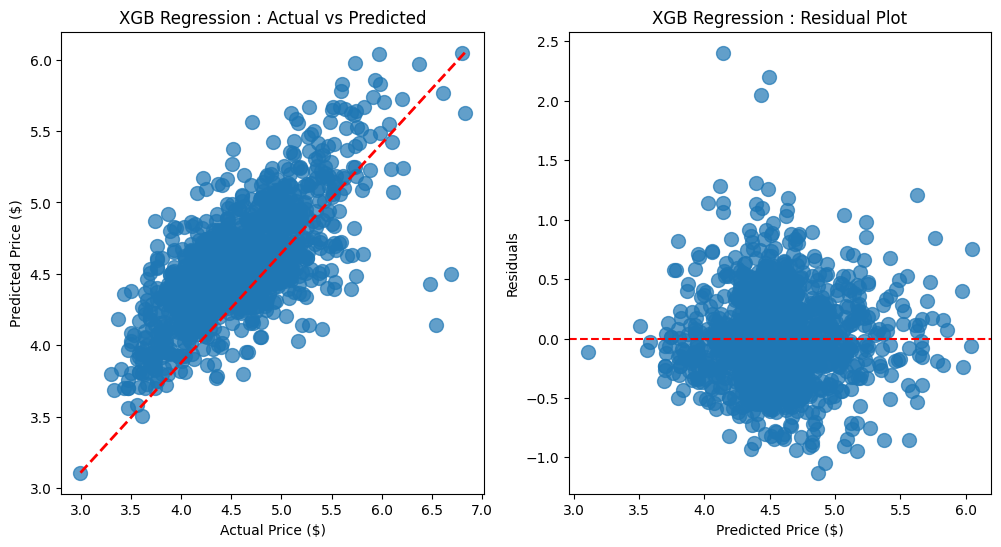

In [33]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100,random_state=42, n_jobs=-1, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42,loss='squared_error'),
    'XGB Regression' : xgb.XGBRegressor(objective='reg:squarederror',learning_rate=0.1,max_depth=3,random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_compare_vals = model.predict(X_val)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_compare_vals)),
        'R²': r2_score(y_val, y_pred_compare_vals),
        'MAE': mean_absolute_error(y_val, y_pred_compare_vals)
    }

    plt.figure(figsize=(12, 6))

    print("Name of Model", name)
    # Plot 1: Predictions vs Actual
    plt.subplot(1, 2, 1)
    plt.scatter(y_val, y_pred_compare_vals, alpha=0.7, s=100)
    plt.plot([y_val.min(), y_val.max()], [y_pred_compare_vals.min(), y_pred_compare_vals.max()], 'r--', lw=2)
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.title(f"{name} : Actual vs Predicted")
    
    # Plot 2: Residuals
    plt.subplot(1, 2, 2)
    residuals = y_val - y_pred_compare_vals
    plt.scatter(y_pred_compare_vals, residuals, alpha=0.7, s=100)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price ($)')
    plt.ylabel('Residuals')
    plt.title(f"{name} : Residual Plot")

# Compare results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(4))

In [34]:
chosen_model = xgb_model

with open('../_models/regression_model.bin', 'wb') as f:
    pickle.dump(chosen_model, f)